In [7]:
from pathlib import Path
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from boplay.acq_funs.mes_utils import sample_yn1_ymax
from boplay.kernels import se_kernel
from boplay.gp import GaussianProcess

import scienceplots

# plt.style.use(['science','no-latex'])
plt.rcParams.update({"text.usetex": True})
plt.style.use(['science', 'grid', 'retro'])


In [8]:
np.random.seed(0)
import boplay

# the parent of the module
SAVE_DIR = Path(boplay.__file__).parent.parent / "paper_plots"
print(f"Pics will be saved to: {SAVE_DIR}")

Pics will be saved to: /lambda/nfs/nethome-us-west-1/lukehg/mes/paper_plots


# Generate Data to Plot

In [9]:


idx_train = np.array([0, 50, 90])

# Generate data to plot
n_yn1 = 41
n_ymax = 1000

# make a grid of x-values
x_grid = np.linspace(0, 100, 101).reshape(-1, 1)
n_x = x_grid.shape[0]

# make a train set of x-values and y-values
x_train = x_grid[idx_train, :]
y_train = np.asarray([0.5, 0.0, 1]).reshape(-1, 1)
y_best = float(max(y_train))

# make a kernel
kernel = partial(se_kernel, len_scale=10.0, sigma_f=1.0)

# make a Gaussian process
gp = GaussianProcess(x_train=x_train, y_train=y_train, kernel=kernel)

# get the mean and covariance of the Gaussian process
y_mean, y_cov = gp.predict(x_test=x_grid)

np.random.seed(0)
y_n1_samples, y_func_samples, y_max_samples, _ = sample_yn1_ymax(
    y_mean=y_mean,
    y_cov=y_cov,
    n_yn1=n_yn1,
    n_ymax=n_ymax,
)




/tmp/ipykernel_443926/60253447.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_best = float(max(y_train))


# Subsample points to make the plot nice and readable

Saved figure to /lambda/nfs/nethome-us-west-1/lukehg/mes/paper_plots/yn1_vs_ymax.pdf


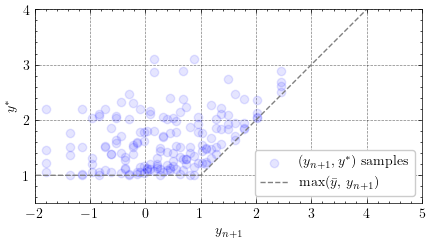

In [10]:
x_idx = 75
np.random.seed(4)

y_n1_samples_x_idx = y_n1_samples[x_idx, :, None]  # (n_yn1, 1)
y_n1_samples_x_idx = np.tile(y_n1_samples_x_idx, (1, n_ymax))  # (n_yn1, n_ymax)
y_max_samples_x_idx = y_max_samples[x_idx, :, :]  # (n_ymax, n_yn1)

# subsample the points to look a bit more random
y_n1_points = []
y_max_points = []
for i in range(n_yn1):
    plot_idx = np.random.choice(n_ymax, replace=False, size=4)
    y_n1_points.extend(list(y_n1_samples_x_idx[i, plot_idx]))
    y_max_points.extend(list(y_max_samples_x_idx[i, plot_idx]))

y_n1_points = np.array(y_n1_points)
y_max_points = np.array(y_max_points)

# plot them
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(
    y_n1_points,
    y_max_points,
    color="blue",
    alpha=0.1,
    label=r"$(y_{n+1}, y^*)$ samples",
)

ax.plot([-100, y_best, 100], [y_best, y_best, 100], linestyle="--", color="grey",
label=r"max($\bar{y}$, $y_{n+1}$)")
ax.set_xlim(-2, 5)
ax.set_ylim(y_best - 0.5, 4)
ax.set_aspect("equal")
ax.set_xlabel("$y_{n+1}$")
ax.set_ylabel("$y^*$")

ax.legend(loc="lower right")
fig.savefig(SAVE_DIR / "yn1_vs_ymax.pdf")
print("Saved figure to", SAVE_DIR / "yn1_vs_ymax.pdf")

# Make Heatmap

/lambda/nfs/nethome-us-west-1/lukehg/mes/boplay/acq_funs/regression_models/lr_het_base.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_trend = pt.tensor(y_trend, **pt_params)
/lambda/nfs/nethome-us-west-1/lukehg/mes/boplay/acq_funs/regression_models/lr_het_base.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_log_sdev = pt.tensor(noise_log_sdev, **pt_params)


Text(0, 0.5, '$y^*$')

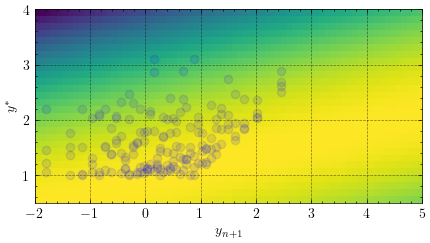

In [11]:
from boplay.acq_funs.regression_models import (
    fit_lr_1_0,
    fit_lr_1_1,
    fit_lr_1_2,
    fit_lr_2_0,
    fit_lr_2_1,
    fit_lr_2_2,
)

# add a row dimension to the data
x_data = y_n1_points[None, :]
y_data = y_max_points[None, :]


make_heatmap_0_0 = fit_lr_1_0(
    x_data=x_data,
    y_data=y_data,
    x_min=y_best,
    make_heatmap=True,
)

y_n1_grid = np.linspace(-2, 5, 71)
y_max_grid = np.linspace(0.5, 4, 36)

y_n1_grid_2d = np.tile(y_n1_grid, len(y_max_grid))
y_max_grid_2d = np.repeat(y_max_grid, len(y_n1_grid))

heatmap = make_heatmap_0_0(
    row_idx=0,  # the heatmap for the 0th row of the initial data
    x=y_n1_grid_2d,
    y=y_max_grid_2d
)

heatmap = heatmap.reshape(len(y_max_grid), len(y_n1_grid))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(heatmap, origin="lower", extent=[-2, 5, - 0.5, 4])

ax.scatter(y_n1_points, y_max_points, color="blue", alpha=0.1)

ax.set_xlim(-2, 5)
ax.set_ylim(y_best - 0.5, 4)
ax.set_aspect("equal")
ax.set_xlabel("$y_{n+1}$")
ax.set_ylabel("$y^*$")


In [12]:
np.tile([11,12,13,14], 5).reshape(5, 4)

array([[11, 12, 13, 14],
       [11, 12, 13, 14],
       [11, 12, 13, 14],
       [11, 12, 13, 14],
       [11, 12, 13, 14]])